In [80]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from multiprocessing import cpu_count
from torch.nn import functional as F

In [81]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
pass

In [82]:
df = pd.read_csv(r'C:\Users\neele\OneDrive\Documents\Dataset\series\training\x_train.csv')

In [83]:
dfy = pd.read_csv(r'C:\Users\neele\OneDrive\Documents\Dataset\series\training\y_train.csv')

In [84]:
df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [85]:
dfy.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [86]:
enc = LabelEncoder()
y_enc = enc.fit_transform(dfy['surface'])
y_enc

array([2, 1, 1, ..., 2, 7, 5])

In [87]:
dfy['encoding'] = y_enc

In [12]:
df_grouped = df.groupby('series_id')

data = []

columns = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z']

for i, item in enumerate(df_grouped):
    
    group_data = []
    # print(item[1])

    for row in item[1].iterrows():

        row_data = []
        
        for column in columns:
            
            row_data.append(row[1][column])

        group_data.append(row_data)

    data.append((group_data,y_enc[i])) 
    

In [13]:
data_df = pd.DataFrame(data, columns=['X','y'])

In [14]:
X = list(data_df['X'])

In [15]:
y = list(data_df['y'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [17]:
len(X_train)

3429

In [18]:
x_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)

x_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [30]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_ds, 128, shuffle=True)
test_loader = DataLoader(valid_ds, 128, shuffle=False)

In [23]:
class LSTMModule(nn.Module):

    def __init__(self):
        super(LSTMModule, self).__init__()

        self.input_layer_size = 10
        self.hidden_layer_size = 256
        self.output_layer_size = 9

        self.lstm = nn.LSTM(self.input_layer_size, self.hidden_layer_size, 3, batch_first=True)
        self.fc = nn.Linear(self.hidden_layer_size, self.output_layer_size)

    def forward(self, input_seq):

        self.hidden_cell = (torch.zeros(3,input_seq.size(0),self.hidden_layer_size).to(device), torch.zeros(3,input_seq.size(0),self.hidden_layer_size).to(device))

        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.fc(lstm_out[:, -1, :])
        return predictions

In [37]:
model = LSTMModule().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [90]:
epochs = 50

running_loss_history = []
epoch_list = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for epoch in range(epochs):

    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    running_loss = 0.0

    model.train()

    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        model.hidden_cell = (torch.zeros(3, 1, 256).to(device), torch.zeros(3, 1, 256).to(device))

        output = model(inputs)

        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = F.log_softmax(output, dim=1).argmax(dim=1)
        running_loss += loss.item()
        running_corrects += (preds == labels).sum().item()

    else:
        correct, total = 0, 0
        model.eval()
        
        with torch.no_grad():

            for val_inputs, val_labels in test_loader:

                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                val_preds = F.log_softmax(val_outputs, dim=1).argmax(dim=1)

                total += val_labels.size(0)

                val_running_loss += val_loss.item()
                val_running_corrects += (val_preds  == val_labels).sum().item()

    
    if epoch % 5 == 0:

        epoch_loss = running_loss/len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss/len(test_loader.dataset)
        val_epoch_acc = val_running_corrects / len(test_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (epoch+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc))

        epoch_list.append(epoch + 1)

        print('_'*20)
    
    

epoch : 1
training loss: 0.0053, acc 0.7629 
validation loss: 0.0066, validation acc 0.6903 
____________________
epoch : 6
training loss: 0.0040, acc 0.8186 
validation loss: 0.0064, validation acc 0.7034 
____________________
epoch : 11
training loss: 0.0031, acc 0.8656 
validation loss: 0.0064, validation acc 0.7375 
____________________
epoch : 16
training loss: 0.0040, acc 0.8227 
validation loss: 0.0071, validation acc 0.7034 
____________________
epoch : 21
training loss: 0.0025, acc 0.8979 
validation loss: 0.0061, validation acc 0.7454 
____________________
epoch : 26
training loss: 0.0018, acc 0.9256 
validation loss: 0.0061, validation acc 0.7480 
____________________
epoch : 31
training loss: 0.0021, acc 0.9113 
validation loss: 0.0062, validation acc 0.7507 
____________________
epoch : 36
training loss: 0.0015, acc 0.9411 
validation loss: 0.0064, validation acc 0.7585 
____________________
epoch : 41
training loss: 0.0014, acc 0.9495 
validation loss: 0.0066, validation 

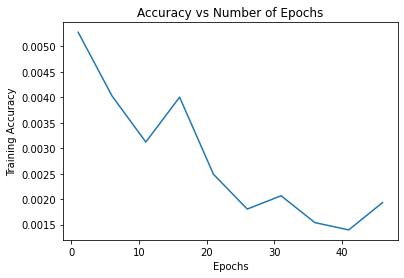

In [91]:
plt.plot(epoch_list,running_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Accuracy vs Number of Epochs")
plt.show()

Text(69.0, 0.5, 'Predicted Values')

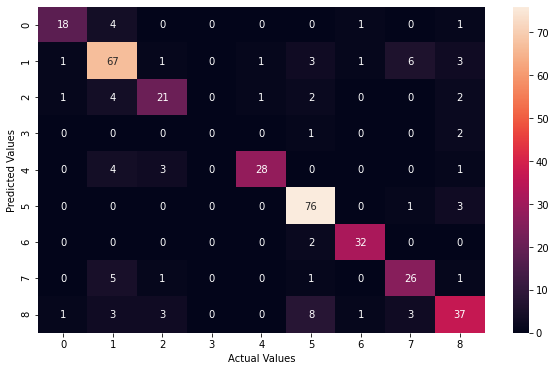

In [92]:
predictions=[]
labels = []

with torch.no_grad():
    model.eval()

    for val_inputs, val_labels in test_loader:

        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        val_preds = F.log_softmax(val_outputs, dim=1).argmax(dim=1)

        predictions += val_preds.cpu().tolist()
        labels += val_labels.cpu().tolist()

        
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(labels,predictions)
cm

plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
   

In [93]:
from sklearn.metrics import accuracy_score
score=accuracy_score(labels,predictions)
score

0.800524934383202